<a href="https://colab.research.google.com/github/pagnihot/pa-pub-test/blob/main/quant-xrayd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
try:
    from google.colab import auth
    GOOGLE_COLAB = True
except ImportError:
    GOOGLE_COLAB = False

In [7]:
if GOOGLE_COLAB:
    !pip install google-cloud-pubsub

In [5]:
if GOOGLE_COLAB:
    auth.authenticate_user()

NameError: ignored

In [4]:
from google import auth
from google.cloud import storage
from google.cloud import pubsub_v1

import datetime, time
import subprocess
import argparse
import os, sys
import json

In [5]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime , time
from math import sqrt
from scipy.stats import norm
import yfinance as yf

In [71]:
STOCK="AMZN"
short_window = 40
long_window = 100
trading_days = 500
sim_num = 100000000
portfolio_stocks_list = ["GOOG","MSFT","NFLX","TSLA","IBM","AMZN"]
portfolio_capital=100000
lookback_days=730

In [7]:
import uuid
sim_id = str(uuid.uuid4())

In [8]:
period_end=datetime.datetime.now()

In [9]:
period_start = period_end - datetime.timedelta(days=lookback_days)

In [10]:
yf.pdr_override()
stock_df = pdr.get_data_yahoo(STOCK,start=period_start, end=period_end)

[*********************100%%**********************]  1 of 1 completed


In [11]:
# Calculate the compound annual growth rate (CAGR) which
# will give us our mean return input (mu)
days = (stock_df.index[-1] - stock_df.index[0]).days
cagr = ((((stock_df['Adj Close'][-1]) / stock_df['Adj Close'][1])) ** (365.0/days)) - 1
mu = cagr

In [12]:
stock_df['Returns'] = stock_df['Adj Close'].pct_change()
vol = stock_df['Returns'].std()*sqrt(252)

In [13]:
initial_capital= float(portfolio_capital)

In [57]:
# Set up empty list to hold our ending values for each simulated price series
sim_result = []

# Set up empty list to hold portfolio value for each simulated price serries, this is the value of position['total']
portfolio_total = []

In [15]:
# Define Variables
start_price = stock_df['Adj Close'][-1] #starting stock price (i.e. last available real stock price)

In [24]:
from typing import Callable

# Define GCP Environment
project_id = "fsif-330919"
topic_id = "QU1"

publisher = pubsub_v1.PublisherClient()
topic_path = publisher.topic_path(project_id, topic_id)
publish_futures = []

In [72]:
def get_callback(publish_future: pubsub_v1.publisher.futures.Future, data: str) -> Callable[[pubsub_v1.publisher.futures.Future], None]:

  def pub_callback(publish_future: pubsub_v1.publisher.futures.Future) -> None:
    try:
      # Wait 60 seconds for the publish call to succeed.
      #print(publish_future.result(timeout=60))
      publish_future.result(timeout=60)
    except futures.TimeoutError:
      print(f"Publishing {data} timed out.")

  return pub_callback

In [18]:
def sub_callback(message: pubsub_v1.subscriber.message.Message) -> None:
  """Process received message"""
  print(f"Received message: ID={message.message_id} Data={message.data}")
  print(f"[{datetime.datetime.now()}] Processing: {message.message_id}")
  sim_data = json.loads(message.data)
  sim_num          = sim_data["sim_num"]
  sim_result.append(sim_data["stock_price"])
  portfolio_total.append(sim_data["portfolio_value"])
  print(f"[{datetime.datetime.now()}] Processed: {message.message_id}")
  message.ack()

In [ ]:
for i in range(sim_num):
  data = f'{{ "sim_id": "{sim_id}", "sim_num": {i}, "stock": "{STOCK}", "short_window": {short_window}, "long_window": {long_window}, "trading_days": {trading_days}, "start_price": {start_price}, "lookback_days": {lookback_days}, "mu": {mu}, "vol": {vol}, "initial_capital": {initial_capital}  }}'
  #print(data)
  publish_future = publisher.publish(topic_path, data.encode("utf-8"))
  # Non-blocking. Publish failures are handled in the callback function.
  publish_future.add_done_callback(get_callback(publish_future, data))
  publish_futures.append(publish_future)

print(f"Published {i} messages with error handler to {topic_path}.")


In [2]:
from google.api_core import retry

In [3]:
r_topic_id = "QU1R"
subscription_id = f'{r_topic_id}-sub1'

subscriber = pubsub_v1.SubscriberClient()
subscription_path = subscriber.subscription_path(project_id, subscription_id)

NameError: ignored

In [44]:
"""
streaming_pull_future = subscriber.subscribe(subscription_path, callback=sub_callback,max_messages=sim_num)
print(f"Pulling messages from {subscription_path}..., in project:{project_id}")

with subscriber:
  try:
    streaming_pull_future.result()
  except Exception as e:
    print(e)
"""

'\nstreaming_pull_future = subscriber.subscribe(subscription_path, callback=sub_callback,max_messages=sim_num)\nprint(f"Pulling messages from {subscription_path}..., in project:{project_id}")\n\nwith subscriber:\n  try:\n    streaming_pull_future.result()\n  except Exception as e:\n    print(e)\n'

In [67]:
with subscriber:
  # The subscriber pulls a specific number of messages. The actual
  # number of messages pulled may be smaller than max_messages.
  response = subscriber.pull(
    request={"subscription": subscription_path, "max_messages": sim_num},
    retry=retry.Retry(deadline=300),
  )

  if len(response.received_messages) != 0:
    ack_ids = []
    for received_message in response.received_messages:
      print(f"Received: {received_message.message.data}.")
      sim_data = json.loads(received_message.message.data)
      sim_num  = sim_data["sim_num"]
      sim_result.append(sim_data["stock_price"])
      portfolio_total.append(sim_data["portfolio_value"])

    ack_ids.append(received_message.ack_id)
    # Acknowledges the received messages so they will not be sent again.
    subscriber.acknowledge(request={"subscription": subscription_path, "ack_ids": ack_ids})

    print(f"Received and acknowledged {len(response.received_messages)} messages from {subscription_path}.")
  else:
    print(f"Received {len(response.received_messages)} messages from {subscription_path}.")


Received: b'{ "sim_num": 79913, "stock_price": 80.03377622915976, "portfolio_value": 94051.42458821402 }'.
Received: b'{ "sim_num": 23688, "stock_price": 70.9769840808192, "portfolio_value": 95620.10537310578 }'.
Received: b'{ "sim_num": 17700, "stock_price": 70.38625365805342, "portfolio_value": 97005.61241025639 }'.
Received: b'{ "sim_num": 38182, "stock_price": 74.89970328271244, "portfolio_value": 95976.64960701298 }'.
Received: b'{ "sim_num": 88170, "stock_price": 119.41021059819091, "portfolio_value": 101048.8733202055 }'.
Received: b'{ "sim_num": 89201, "stock_price": 197.22267437985377, "portfolio_value": 94570.90591285311 }'.
Received: b'{ "sim_num": 26693, "stock_price": 151.50156426491628, "portfolio_value": 101771.64250639261 }'.
Received: b'{ "sim_num": 26542, "stock_price": 154.3290264343383, "portfolio_value": 97756.76202996065 }'.
Received: b'{ "sim_num": 23861, "stock_price": 164.648503694788, "portfolio_value": 98746.2536977105 }'.
Received: b'{ "sim_num": 93693, "sto

In [58]:
import matplotlib.pyplot as plt

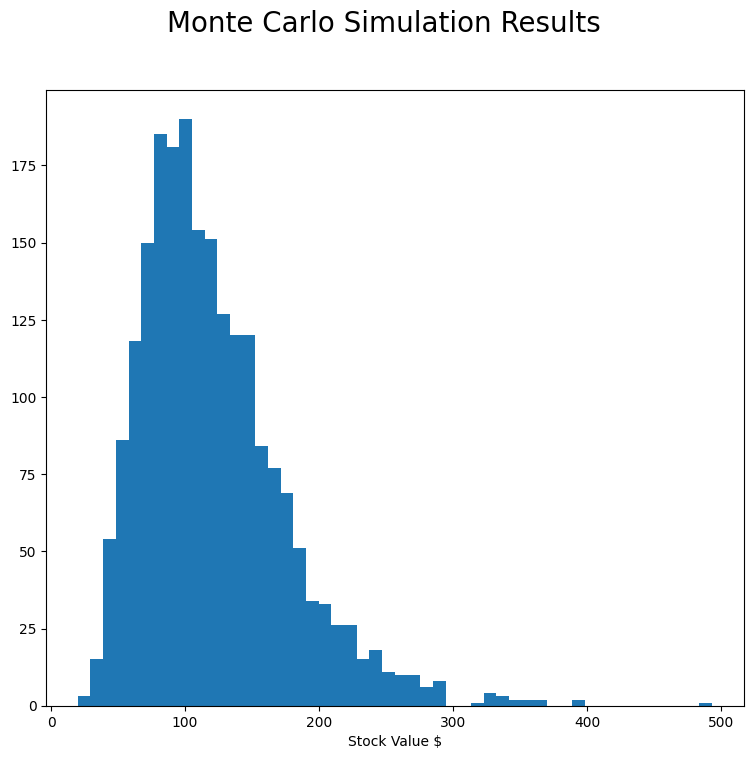

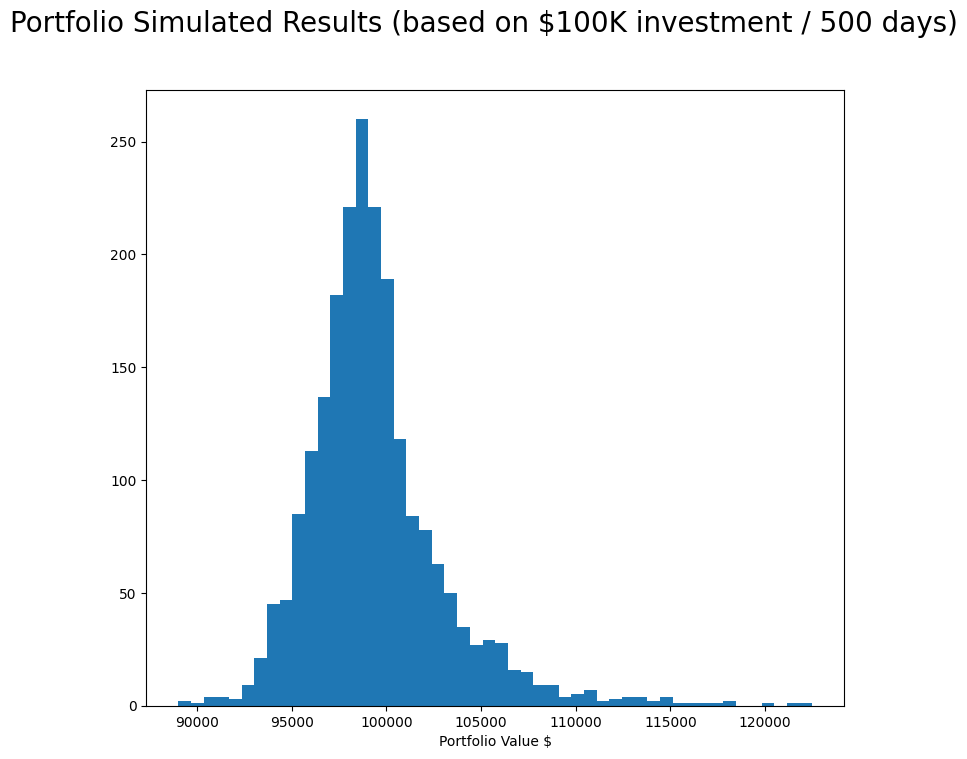

In [68]:
#create histogram of ending stock values for our mutliple simulations
plt.rcParams["figure.figsize"] = (9,8)
plt.hist(sim_result,bins=50)
plt.suptitle('Monte Carlo Simulation Results', fontsize=20)
plt.xlabel('Stock Value $')
plt.show()

#create histogram of ending protfolio values for our mutliple simulations, compare this value to "initial_capital"
plt.hist(portfolio_total,bins=50)
plt.suptitle('Portfolio Simulated Results (based on $100K investment / ' + str(trading_days) + ' days)', fontsize=20)
plt.xlabel('Portfolio Value $')
plt.show()